In [7]:
import pandas as pd

# Load the uploaded BTC 1H CSV file
file_path = '/home/int_j/Documents/Art Draft/Data Science/Adaptive Learning/XAUUSD_H1.csv'
xau_data = pd.read_csv(file_path)

# Display basic information about the dataset
xau_data_info = xau_data.info()
xau_data_head = xau_data.head()

xau_data_info, xau_data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 1 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   <DATE>	<TIME>	<OPEN>	<HIGH>	<LOW>	<CLOSE>	<TICKVOL>	<VOL>	<SPREAD>  880 non-null    object
dtypes: object(1)
memory usage: 7.0+ KB


(None,
   <DATE>\t<TIME>\t<OPEN>\t<HIGH>\t<LOW>\t<CLOSE>\t<TICKVOL>\t<VOL>\t<SPREAD>
 0  2025.05.15\t01:00:00\t3180.57\t3183.97\t3180.1...                        
 1  2025.05.15\t02:00:00\t3182.55\t3187.02\t3181.1...                        
 2  2025.05.15\t03:00:00\t3186.00\t3187.71\t3180.1...                        
 3  2025.05.15\t04:00:00\t3187.57\t3192.65\t3171.1...                        
 4  2025.05.15\t05:00:00\t3172.40\t3175.49\t3149.9...                        )

In [2]:
# Reload the data with tab-separated values
xau_data = pd.read_csv(file_path, delimiter='\t')

# Display basic information and the first few rows after parsing
xau_data_info = xau_data.info()
xau_data_head = xau_data.head()

xau_data_info, xau_data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   <DATE>     880 non-null    object 
 1   <TIME>     880 non-null    object 
 2   <OPEN>     880 non-null    float64
 3   <HIGH>     880 non-null    float64
 4   <LOW>      880 non-null    float64
 5   <CLOSE>    880 non-null    float64
 6   <TICKVOL>  880 non-null    int64  
 7   <VOL>      880 non-null    int64  
 8   <SPREAD>   880 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 62.0+ KB


(None,
        <DATE>    <TIME>   <OPEN>   <HIGH>    <LOW>  <CLOSE>  <TICKVOL>  <VOL>  \
 0  2025.05.15  01:00:00  3180.57  3183.97  3180.12  3182.56       2141      0   
 1  2025.05.15  02:00:00  3182.55  3187.02  3181.14  3186.01       2907      0   
 2  2025.05.15  03:00:00  3186.00  3187.71  3180.12  3187.58       5851      0   
 3  2025.05.15  04:00:00  3187.57  3192.65  3171.15  3172.22      11466      0   
 4  2025.05.15  05:00:00  3172.40  3175.49  3149.99  3154.19      12356      0   
 
    <SPREAD>  
 0        35  
 1        26  
 2        20  
 3        20  
 4        18  )

In [7]:
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import StandardScaler

# Split the single column into proper columns
if len(xau_data.columns) == 1:
    # Extract column headers from the first row
    headers = xau_data.columns[0].split('\t')
    
    # Split data into separate columns
    xau_data = xau_data[xau_data.columns[0]].str.split('\t', expand=True)
    xau_data.columns = headers

# Convert columns to proper data types
numeric_cols = ['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>', '<VOL>', '<SPREAD>']
xau_data[numeric_cols] = xau_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Clean and create features
xau_data = xau_data.dropna()
xau_data['return'] = xau_data['<CLOSE>'].pct_change()

# Add technical indicators
xau_data['rsi'] = ta.momentum.RSIIndicator(xau_data['<CLOSE>'], window=14).rsi()
xau_data['macd'] = ta.trend.MACD(xau_data['<CLOSE>']).macd_diff()
xau_data['sma_20'] = ta.trend.SMAIndicator(xau_data['<CLOSE>'], window=20).sma_indicator()
xau_data['sma_50'] = ta.trend.SMAIndicator(xau_data['<CLOSE>'], window=50).sma_indicator()
xau_data = xau_data.dropna()

# Normalize features
scaler = StandardScaler()
features = ['rsi', 'macd', 'sma_20', 'sma_50', 'return']
xau_data[features] = scaler.fit_transform(xau_data[features])

In [17]:
import gym
from gym import spaces

class TradingEnv(gym.Env):
    def __init__(self, df, window_size=30, initial_balance=10000):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.action_space = spaces.Discrete(3)  # 0: hold, 1: buy, 2: sell

        # ✅ FIX: Use correct shape (window_size, number of features)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.window_size, len(features)), dtype=np.float32
        )

    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.position = 0  # 1 = long, -1 = short, 0 = neutral
        self.entry_price = 0
        self.trades = []
        return self._next_observation()

    def _next_observation(self):
        # FIX: Use iloc to prevent overshooting shape
        obs = self.df.iloc[self.current_step - self.window_size : self.current_step]
        obs = obs[features].values
        return obs

    def step(self, action):
        current_price = self.df.loc[self.current_step, '<CLOSE>']
        reward = 0

        if action == 1 and self.position == 0:  # Buy
            self.position = 1
            self.entry_price = current_price
        elif action == 2 and self.position == 0:  # Sell
            self.position = -1
            self.entry_price = current_price
        elif action == 0 and self.position != 0:  # Close position
            if self.position == 1:
                reward = current_price - self.entry_price
            elif self.position == -1:
                reward = self.entry_price - current_price
            self.position = 0

        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        obs = self._next_observation()
        return obs, reward, done, {}


In [18]:
import torch.nn as nn
import torch.nn.functional as F

class DuelingDQN(nn.Module):
    def __init__(self, state_shape, action_dim):
        super(DuelingDQN, self).__init__()
        # Calculate flattened dimension
        flattened_dim = np.prod(state_shape)
        
        # Network layers
        self.fc1 = nn.Linear(flattened_dim, 128)
        
        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, state):
        # Flatten state while keeping batch dimension
        x = state.view(state.size(0), -1)
        x = F.relu(self.fc1(x))
        value = self.value_stream(x)
        advantages = self.advantage_stream(x)
        return value + (advantages - advantages.mean(dim=1, keepdim=True))

In [19]:
# Training loop parameters
env = TradingEnv(xau_data)

# Use positional arguments instead of keyword arguments
model = DuelingDQN(150, 3)  # input_dim=150 (flattened state), action_dim=3
target_model = DuelingDQN(150, 3)  # Same dimensions
target_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [20]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return (
            torch.tensor(state, dtype=torch.float32),          # Shape: [batch, state_dim]
            torch.tensor(action, dtype=torch.int64),           # ✅ Should be integer (for indexing)
            torch.tensor(reward, dtype=torch.float32),         
            torch.tensor(next_state, dtype=torch.float32),
            torch.tensor(done, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)


In [30]:
env = TradingEnv(xau_data)
obs_shape = env.observation_space.shape
n_actions = env.action_space.n

# Calculate flattened dimension
flattened_dim = np.prod(obs_shape)  # 30*5 = 150

model = DuelingDQN(flattened_dim, n_actions)
target_model = DuelingDQN(flattened_dim, n_actions)
target_model.load_state_dict(model.state_dict())

optimizer = optim.Adam(model.parameters(), lr=0.0005)
buffer = ReplayBuffer()
gamma = 0.99
epsilon = 1.0
batch_size = 64
target_update_interval = 10

all_rewards = []
all_actions = []  # We'll collect actions for the entire dataset

# Training loop
for episode in range(200):
    state = env.reset()
    total_reward = 0
    done = False
    episode_actions = []  # Store actions for this episode

    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                # Flatten state and pass to model
                state_tensor = torch.tensor(state, dtype=torch.float32).flatten().unsqueeze(0)
                q_values = model(state_tensor)
                action = q_values.argmax().item()
        
        next_state, reward, done, _ = env.step(action)
        buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        episode_actions.append(action)  # Record action

        if len(buffer) >= batch_size:
            s, a, r, s2, d = buffer.sample(batch_size)

            q_val = model(s).gather(1, a.unsqueeze(1)).squeeze()
            next_q_val = target_model(s2).max(1)[0]
            target = r + (1 - d) * gamma * next_q_val

            loss = nn.MSELoss()(q_val, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    epsilon = max(0.01, epsilon * 0.995)
    if episode % target_update_interval == 0:
        target_model.load_state_dict(model.state_dict())
        print(f"Episode {episode}, Reward: {total_reward}")

    # After episode completes
    all_rewards.append(total_reward)
    all_actions.extend(episode_actions)  # Add episode actions to master list


Episode 0, Reward: -136.58999999999924
Episode 10, Reward: -124.05000000000018
Episode 20, Reward: 204.88999999999896
Episode 30, Reward: 318.0400000000036
Episode 40, Reward: 390.2200000000057
Episode 50, Reward: -104.13000000000238
Episode 60, Reward: 44.12000000000489
Episode 70, Reward: -51.08000000000311
Episode 80, Reward: 207.67999999999938
Episode 90, Reward: -175.0600000000013
Episode 100, Reward: -274.30000000000564
Episode 110, Reward: -138.99000000000024
Episode 120, Reward: -163.40000000000236
Episode 130, Reward: -348.3800000000024
Episode 140, Reward: 351.7799999999975
Episode 150, Reward: 172.8699999999999
Episode 160, Reward: -43.169999999995525
Episode 170, Reward: -134.75000000000136
Episode 180, Reward: -35.96999999999571
Episode 190, Reward: -194.4600000000023


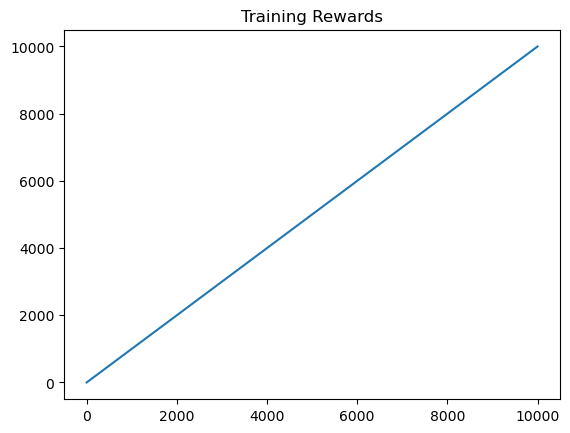

In [31]:
import matplotlib.pyplot as plt

# Plotting performance metrics like cumulative reward
plt.plot([r for r in range(len(buffer.buffer))], label="Reward Trend")
plt.title("Training Rewards")
plt.show()


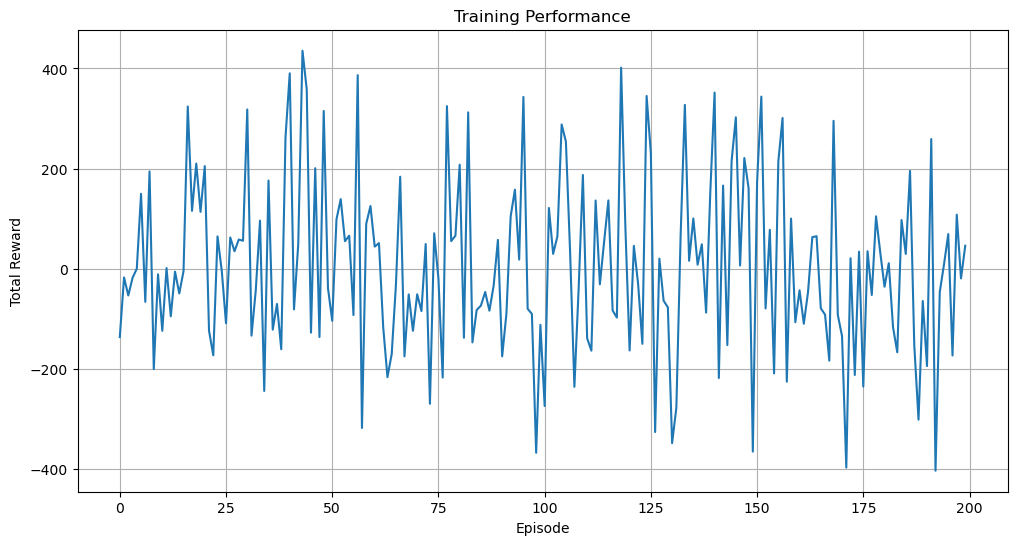

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(all_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance")
plt.grid(True)
plt.show()


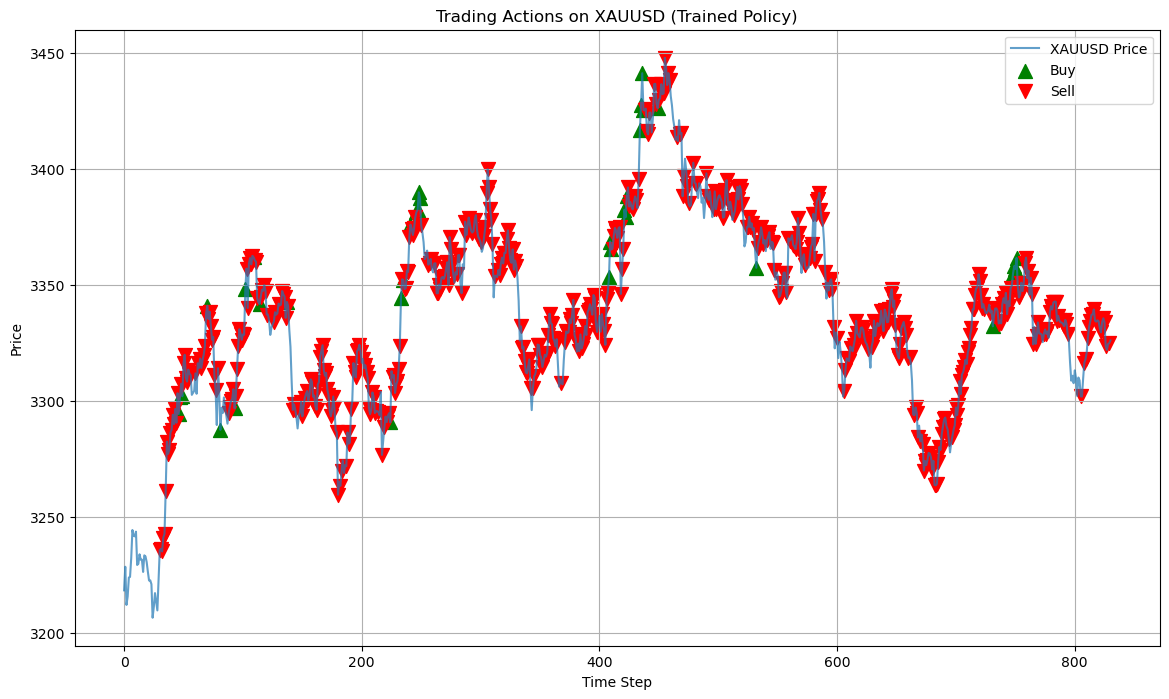

In [34]:
# Run a clean evaluation with the trained model (no exploration)
eval_env = TradingEnv(xau_data)
state = eval_env.reset()
eval_actions = []  # Store actions for this single episode

with torch.no_grad():
    while True:
        # Flatten state and predict
        state_tensor = torch.tensor(state, dtype=torch.float32).flatten().unsqueeze(0)
        q_values = model(state_tensor)
        action = q_values.argmax().item()
        
        next_state, _, done, _ = eval_env.step(action)
        eval_actions.append(action)
        state = next_state
        
        if done:
            break

# Now plot using eval_actions
close_prices = xau_data['<CLOSE>'].values
window_size = eval_env.observation_space.shape[0]

# Create action array with same length as price data
action_array = np.full(len(close_prices), np.nan)
action_array[window_size:window_size + len(eval_actions)] = eval_actions

# Create plot
plt.figure(figsize=(14, 8))
plt.plot(close_prices, label='XAUUSD Price', alpha=0.7)

# Plot buy signals (action=1)
buy_mask = (action_array == 1)
buy_indices = np.where(buy_mask)[0]
plt.scatter(buy_indices, close_prices[buy_mask], 
            color='green', label='Buy', marker='^', s=100)

# Plot sell signals (action=2)
sell_mask = (action_array == 2)
sell_indices = np.where(sell_mask)[0]
plt.scatter(sell_indices, close_prices[sell_mask], 
            color='red', label='Sell', marker='v', s=100)

plt.legend()
plt.title("Trading Actions on XAUUSD (Trained Policy)")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.grid(True)
plt.show()


In [36]:
dummy_input = torch.randn(1, *obs_shape)
torch.onnx.export(model, dummy_input, "dueling_dqn_xauusd.onnx",
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}})
